In [ ]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


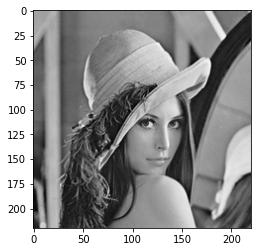

(220, 220)
48400


In [ ]:
img = cv2.imread('/content/drive/My Drive/Deep Learning Prof/Redes Convolucionales/220px-Lenna_(test_image).png', cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap= 'gray')
plt.show()
print(img.shape)
print(img.shape[0]*img.shape[1])

In [ ]:
class Conv:
  def __init__(self, num_filters, filter_size):
    #Numero de filtros que vamos a usar
    self.num_filters = num_filters
    #Tamaño de cada filtro que vamos a usar
    self.filter_size = filter_size
    #Nuestra capa convolucional tiene N filtros de tamaño KxK (cada filtro va a escanear toda la imagen)
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size)/filter_size*filter_size

  #Obtenemos trozos de la imagen
  def image_region(self, image):
    #Magnitud de la imagen
    height, width = image.shape
    #Guardamos la imagen 
    self.image = image
    
    for j in range(height - self.filter_size + 1):
      for k in range(width - self.filter_size + 1):
        #Cogemos una seccion de la imagen
        image_patch = image[j : (j + self.filter_size), k : (k + self.filter_size)]
        #La devolvemos
        yield image_patch, j, k
  
  def forward_prop(self, image):
    #obtenemos el tamaño de la imagen
    height, width = image.shape
    #creamos la imagen resultante, que sera resultado de multiplicar
    #cada seccion de la imagen por los filtros que hemos definido y que estan
    #inicializados de forma aleatoria
    conv_out = np.zeros( (height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters) )
    
    #obtenemos el resultado para todos los filtros
    for image_patch, i, j in self.image_region(image):
      conv_out[i, j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
    return conv_out
  
  def back_prop(self, dL_dout, learning_rate):
    #tantos parametros como filtros y tamaño de estos
    dL_dF_params = np.zeros(self.conv_filter.shape)
    
    #para cada filtro .....
    for image_patch, i, j in self.image_region(self.image):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch*dL_dout[i,j,k]
    
    #aplicamos descenso del gradiente
    self.conv_filter -= learning_rate*dL_dF_params
    return dL_dF_params

In [ ]:
conn = Conv(18, 7)
out = conn.forward_prop(img)
out.shape

(214, 214, 18)

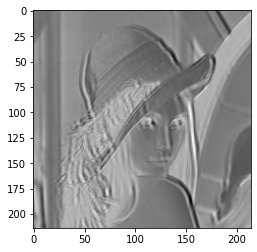

In [ ]:
plt.imshow(out[:,:,4], cmap='gray')
plt.show()

In [ ]:
class Max_pool:
  def __init__(self, filter_size):
    #Tamaño del filtro
    self.filter_size = filter_size
  
  def image_region(self, image):
    #vamos a tener tantos elementos como la divison entera
    #si algun segmento nos queda fuera (por ejemplo MaxPolling(3) y la matriz)
    #no es divisible por 3 pues la matriz sobrante (por ejemplo una 2x1) se usara
    #para el maximo
    new_height = image.shape[0] // self.filter_size
    new_width  = image.shape[1] // self.filter_size
    self.image = image

    #damos las secciones de la imagen
    for i in range(new_height):
      for j in range(new_width):
        image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size),\
                            (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
        yield image_patch, i, j
  
  def forward_prop(self, image):
    height, width, num_filters = image.shape
    #las dimensiones seran las mismas que las definidas previamente
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    #para cada matriz cogemos el maximo
    for image_patch, i, j in self.image_region(image):
      output[i,j] = np.amax(image_patch, axis = (0,1))

    return output

  def back_prop(self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis = (0,1))

      for i1 in range(height):
        for j1 in range(width):
          for k in range(num_filters):
            if image_patch[i1,j1,k] == maximum_val[k]:
              dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k] = dL_dout[i,j,k]
    
    return dL_dmax_pool



In [ ]:
conn2 = Max_pool(4)
out2 = conn2.forward_prop(out)
out2.shape

(53, 53, 18)

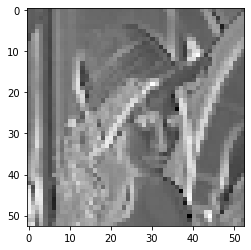

In [ ]:
plt.imshow(out2[:,:,2], cmap='gray')
plt.show()

In [ ]:
class Softmax:
  def __init__(self, input_node, softmax_node):

    #La cantidad de pesos y de bias
    self.weigth = np.random.randn(input_node, softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):
    
    self.orig_im_shape = image.shape
    #Aplastam,os la imagen
    image_modified = image.flatten()
    self.modified_input = image_modified
    #Hacemos dot product de la entrada por los pesos mas el bias
    output_val = np.dot(image_modified, self.weigth) + self.bias
    self.out = output_val
    #Aplicamos la funcion de Activacion Softmax
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis=0)

  def back_prop(self, dL_dout, learning_rate):
    for i, grad in enumerate(dL_dout):
      if grad == 0:
        continue
      
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      #Gradient with respect to out 
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total**2)
      dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)


      #Gradients of totals against weights/biases/input
      dz_dw = self.modified_input
      dz_db = 1
      dz_d_inp = self.weigth

      #Gradient of loss against totals
      dL_dz = grad * dy_dz

      #Gradients of loss against weights/biasses/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

      #Update
      self.weigth -= learning_rate * dL_dw
      self.bias -= learning_rate * dL_db

      return dL_d_inp.reshape(self.orig_im_shape)



In [ ]:
conn3 = Softmax(53*53*18, 10)
out3 = conn3.forward_prop(out2)
print(out3)

[0.09757422 0.09973615 0.09851833 0.09932699 0.10252806 0.09697308
 0.10264731 0.10049724 0.10090058 0.10129803]


In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

conv = Conv(8, 3)               # 28x28x1  -> 26x26x8
pool = Max_pool(2)              # 26x26x8  -> 13x13x8
softmax = Softmax(13*13*8, 10)  # 13x13x8  -> 10


def cnn_forward_prop(image, label):
  out_p1 = conv.forward_prop((image / 255) - 0.5)
  out_p2 = pool.forward_prop(out_p1)
  out_p3 = softmax.forward_prop(out_p2)

  cross_ent_loss = -np.log(out_p3[label])
  accuracy = 1 if np.argmax(out_p3) == label else 0

  return out_p1, out_p2, out_p3, cross_ent_loss, accuracy

In [ ]:
def training(image, label, learning_rate=0.01):

  #Forward
  out_conv, out_Maxpool, out_soft, loss, acc = cnn_forward_prop(image, label)

  #Initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out_soft[label]

  #Backprop
  grad_back = softmax.back_prop(gradient, learning_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learning_rate)

  return loss, acc, out_conv, out_Maxpool, out_soft

In [ ]:
out_conv = None
out_Maxpool = None
out_soft = None

total_loss = []

Train = True
if Train:
  for it in range(3):
    print('Epoch %d -->' % (it + 1))

    #Shuffle the training data
    shuffle_data = np.random.permutation(len(train_images))
    train_images = train_images[shuffle_data]
    train_labels = train_labels[shuffle_data]

    #Training
    loss = 0
    num_correct = 0
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
      if i % 100 == 0:
        total_loss.append(loss/100)
        print('%d steps out of 100 steps: Average Loss %.3f , Accuracy: %d%%' %(i+1, loss/100, num_correct))
        loss = 0
        num_correct = 0
      
      loss_sum, acu, out_conv, out_Maxpool, out_soft = training(im, label)
      loss += loss_sum
      num_correct += acu
  else:
    print('Testing')
    loss = 0
    num_correct = 0
    for im, label in zip(test_images, test_labels):
      out_conv, out_Maxpool, out_soft, loss_sum, accu = cnn_forward_prop(im, label)
      loss += loss_sum
      num_correct += accu
    
    num_test = len(test_images)
    print('Test Loss:', loss / num_test)
    print('Test Accuracy:', num_correct / num_test)



Epoch 1 -->
1 steps out of 100 steps: Average Loss 0.000 , Accuracy: 0%
101 steps out of 100 steps: Average Loss 1.858 , Accuracy: 47%
201 steps out of 100 steps: Average Loss 1.032 , Accuracy: 66%
301 steps out of 100 steps: Average Loss 0.755 , Accuracy: 79%
401 steps out of 100 steps: Average Loss 0.498 , Accuracy: 81%
501 steps out of 100 steps: Average Loss 0.862 , Accuracy: 74%
601 steps out of 100 steps: Average Loss 0.213 , Accuracy: 94%
701 steps out of 100 steps: Average Loss 0.492 , Accuracy: 87%
801 steps out of 100 steps: Average Loss 0.729 , Accuracy: 79%
901 steps out of 100 steps: Average Loss 0.744 , Accuracy: 79%
1001 steps out of 100 steps: Average Loss 0.785 , Accuracy: 77%
1101 steps out of 100 steps: Average Loss 0.577 , Accuracy: 87%
1201 steps out of 100 steps: Average Loss 0.465 , Accuracy: 82%
1301 steps out of 100 steps: Average Loss 0.535 , Accuracy: 86%
1401 steps out of 100 steps: Average Loss 0.372 , Accuracy: 89%
Epoch 2 -->
1 steps out of 100 steps: Ave

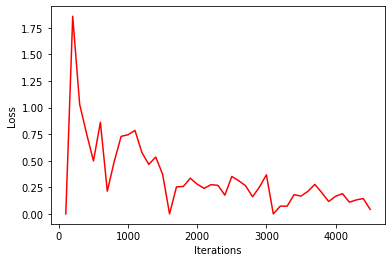

In [ ]:
x = np.linspace(100, 1500*3, 45)

plt.plot(x, total_loss, 'r')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

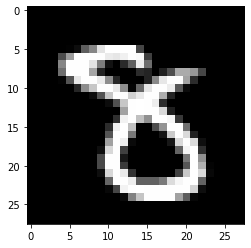

In [ ]:
plt.imshow(X_test[1499], cmap='gray')
plt.show()

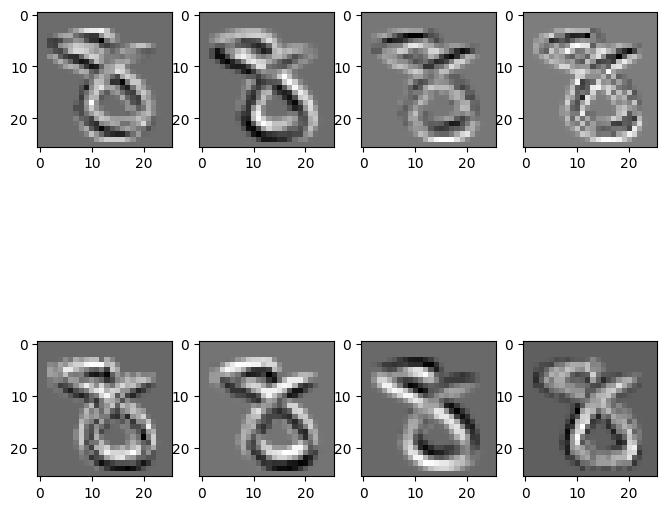

(26, 26, 8)


In [ ]:
fig=plt.figure(figsize=(8, 8), dpi=100)
columns = 4
rows = 2
j = 1
for i in range(out_conv.shape[2]):
    fig.add_subplot(rows, columns, j)
    j += 1
    plt.imshow(out_conv[:,:,i], cmap='gray')
plt.show()
print(out_conv.shape)

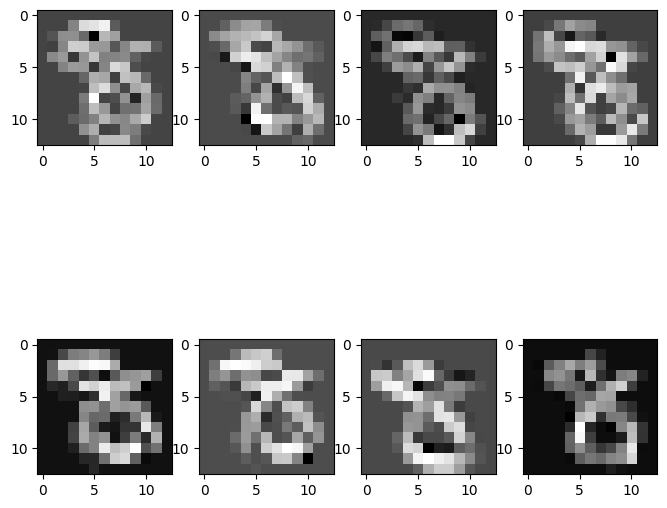

(13, 13, 8)


In [ ]:
fig=plt.figure(figsize=(8, 8), dpi=100)
columns = 4
rows = 2
j = 1
for i in range(out_conv.shape[2]):
    fig.add_subplot(rows, columns, j)
    j += 1
    plt.imshow(out_Maxpool[:,:,i], cmap='gray')
plt.show()
print(out_Maxpool.shape)

In [ ]:
for i in range(10):
    print(out_soft[i], end=', ')
    if (i == 4):
      print('\n')

4.423971397943554e-07, 3.7602692994341407e-06, 0.0076360533704324714, 0.012741918948300018, 7.595867416370345e-06, 

0.0016323391027514445, 8.11592203280084e-09, 0.0001753240730176345, 0.9777737979472932, 2.8759908427652116e-05, 

In [16]:
def yield_func():
  i = 1
  while True:
    yield i
    i += 1

y = yield_func()


In [34]:
next(y)

18